# Water4Cities Infrastructure to support Data Mining
### W4C Webinar #1
Klemen Kenda, Matej Senožetnik, JSI @ SingularLogic, Nov 24th 2017

## Importing libraries

In [1]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [2]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=85069";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [3]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

,Value,Date
0,277.80,2015-01-01
1,277.77,2015-01-02
2,277.73,2015-01-03
3,277.70,2015-01-04
4,277.65,2015-01-05


<IPython.core.display.Javascript object>


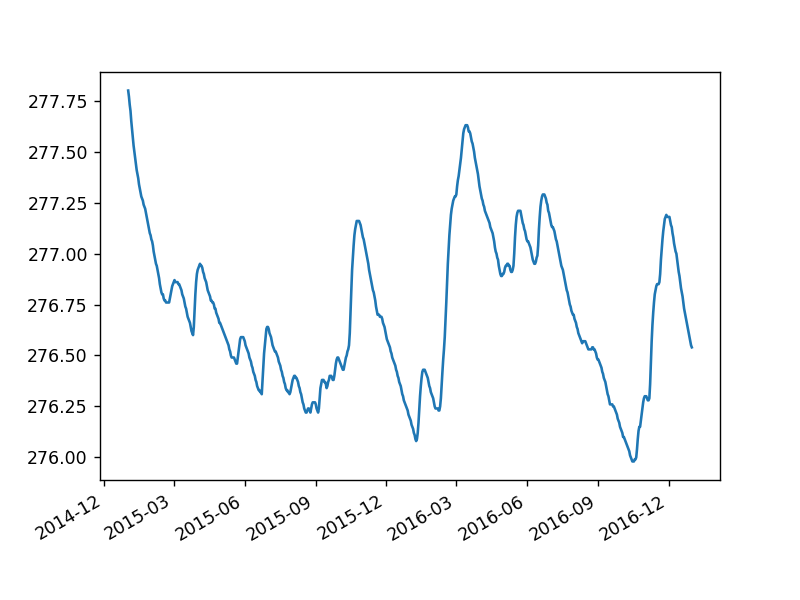

In [4]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [5]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2014&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


In [6]:
dw[0:5]

,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,
2015-01-01,70,0,0.0,13,2.1,-5.8,-3.0,-9.6
2015-01-02,83,0,0.0,12,2.1,-0.6,1.5,-5.5
2015-01-03,80,0,0.0,10,0.0,-1.0,0.6,-4.5
2015-01-04,20,0,0.2,8,7.9,3.1,10.3,-0.5
2015-01-05,50,0,0.0,4,5.9,3.0,8.5,0.0


## Data Fusion

In [7]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [8]:
df[0:5]

,Value
Date,
2015-01-01,277.80
2015-01-02,277.77
2015-01-03,277.73
2015-01-04,277.70
2015-01-05,277.65


In [9]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [10]:
# let's check it
ds[0:10]

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,,
2015-01-01,277.80,70,0,0.0,13,2.1,-5.8,-3.0,-9.6
2015-01-02,277.77,83,0,0.0,12,2.1,-0.6,1.5,-5.5
2015-01-03,277.73,80,0,0.0,10,0.0,-1.0,0.6,-4.5
2015-01-04,277.70,20,0,0.2,8,7.9,3.1,10.3,-0.5
2015-01-05,277.65,50,0,0.0,4,5.9,3.0,8.5,0.0
2015-01-06,277.61,33,0,0.0,3,4.4,-0.4,4.9,-3.6
2015-01-07,277.57,50,0,0.0,3,1.1,-0.9,2.7,-2.7
2015-01-08,277.53,83,0,0.0,3,0.2,0.2,2.3,-4.1
2015-01-09,277.50,90,0,0.0,2,0.6,4.9,7.5,1.0


<IPython.core.display.Javascript object>


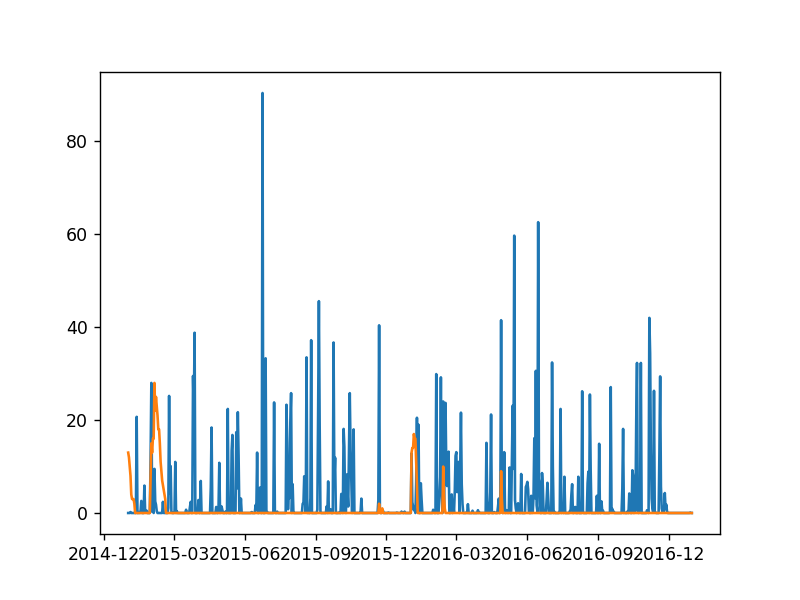

In [11]:
plt.figure(4)
plt.plot(dw['Percipitation'])
plt.plot(dw['Snow_blanket'])

## Exploratory data analysis
This is a very big deal for successful data mining; we will not go deep into this. We will just do some very basic visualizations.

<IPython.core.display.Javascript object>


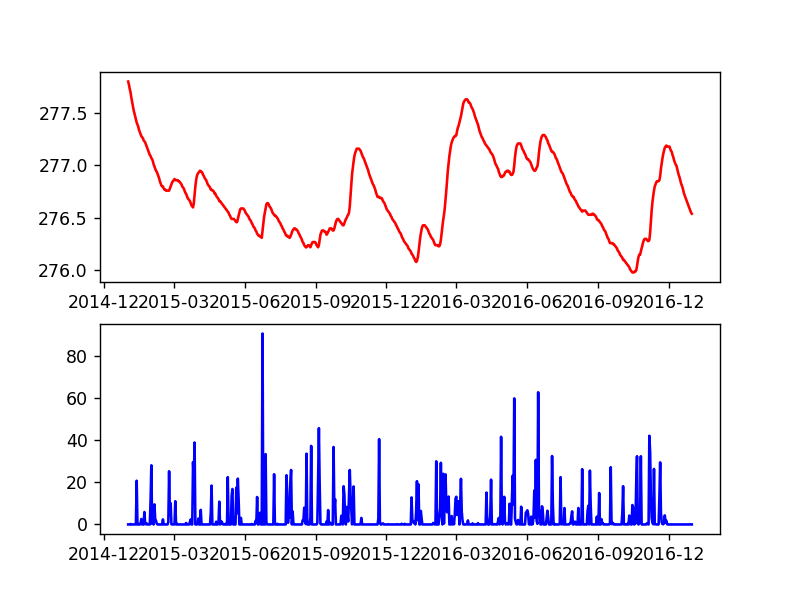

In [12]:
plt.figure(2);
plt.subplot(211);
plt.plot(ds.index, ds['Value'], 'r');
plt.subplot(212);
plt.plot(ds.index, ds['Percipitation'], 'b');
plt.show()

## Let the fun begin!
# Data-driven modeling
How well can we describe groundwater level with tha available features?

In [13]:
# Let's prepare the data, we need a vector y with our groundwater level 
# and a matrix X of corresponding features
y = ds['Value'];
X = ds.iloc[:, 1:9];

In [24]:
# linear regression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


regressor = linear_model.LinearRegression();
#regressor = DecisionTreeRegressor();
#regressor = SVR();
#regressor = RandomForestRegressor();
#regressor = GradientBoostingRegressor();

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(regressor, X, y, cv = 10);

<IPython.core.display.Javascript object>


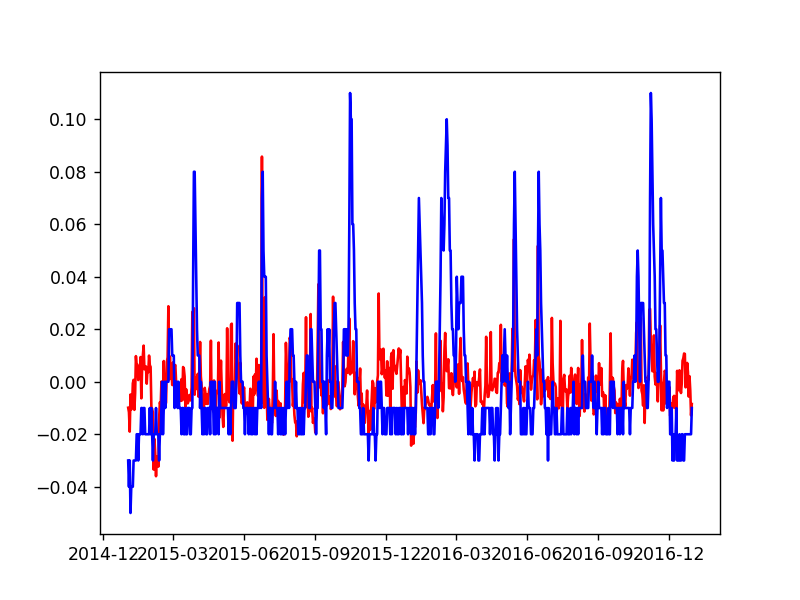

In [25]:
# plot modeling results
fig, ax = plt.subplots();
ax.plot(y.index, predicted, 'r');
ax.plot(y, 'b');
plt.show();

In [26]:
# evaluate model
mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)


(0.0005344302305905326, 0.10112577931934885)

<IPython.core.display.Javascript object>


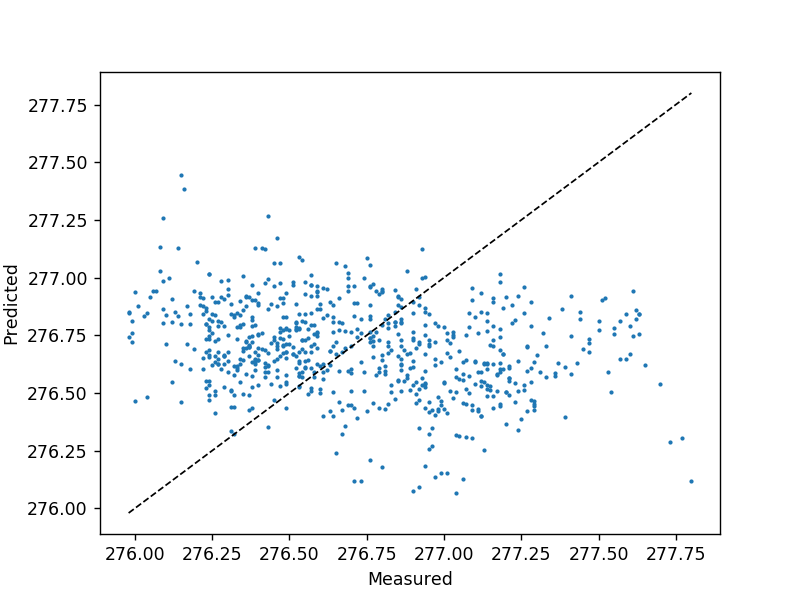

In [17]:
# scatterplot
fig, ax = plt.subplots();
ax.scatter(y, predicted, s=2);
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1);
ax.set_xlabel('Measured');
ax.set_ylabel('Predicted');
plt.show();

## Are we looking at a good target variable?

In [18]:
# make new X and y
y = ds['Value'][:]
X = ds.iloc[1:, 1:10];

In [19]:
y = ds['Value'] - ds['Value'].shift(1)
y = y[1:]

## How about proper feature engineering?
Domain knowledge can help!

See data fusion / stream modeling demo!